Importing TensorFlow

In [1]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [2]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
from imutils import paths
import numpy as np
import time
import cv2
import os

Cloning GitHub repository with the OpenCV text detection EAST algorithm:

In [3]:
!git clone https://github.com/dilhelh/opencv-text-detection.git

Cloning into 'opencv-text-detection'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Receiving objects: 100% (11/11), 86.25 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Uploading image from the Github repo

In [4]:
!python /content/opencv-text-detection/text_detection.py --image /content/opencv-text-detection/images/sign.jpg \
	--east /content/opencv-text-detection/frozen_east_text_detection.pb

[INFO] loading EAST text detector...
[INFO] text detection took 0.776958 seconds
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



# TFLite model conversion
In order to use integer quantization we are using the COCO-Text dataset.

Steps:
**TFLite Model Conversion**: We're talking about converting a machine learning model into a format that's more efficient and faster to run on a device, like your smartphone.

**Float16 Model**: Float16 is a way to represent numbers in the model. It's like using simpler, shorter numbers, which makes the model faster.

**Input Shape: **Think of this as the size and shape of the data you feed into the model. It's like making sure the key fits the lock.

**TFLite GPU Delegate:** This is like having a helper that uses the graphics processing unit (GPU) on your device to do the math even faster.

**Integer Quantization:** We're simplifying numbers again, but this time we need some examples to help the model understand how to do it. It's like teaching it a few tricks.

**Representative Dataset:** Imagine you're teaching a robot to recognize things. You show it lots of pictures to learn. The COCO-Text dataset is like a big book of pictures. To make it easier, we'll start with a smaller book of just 100 pictures. It's like training wheels for the robot.

So, in simple terms, we're making our smart model even smarter by changing how it does math (quantization) and giving it a smaller set of pictures (representative dataset) to learn from, which will make it work faster on our devices.

Loading dataset: to do the quantization

In [5]:
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

In [6]:
IMAGE_LIST = list(paths.list_images('/content/coco_text_100'))
IMG_SIZE = 320

The following code essentially **prepares images for a machine learning model to use**. It reads, resizes, and adjusts the images, and then serves them up one at a time for the model to learn from.

In [7]:
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

 Quantization
 - taking a deep learning model, optimizing it for efficient execution on small devices, and saving it in a format (TensorFlow Lite) that's suitable for running on those devices.

In [8]:
quantization = "int8" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/opencv-text-detection/frozen_east_text_detection.pb',
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)

24822408

# Inference

Prepare an input image

In [9]:
def preprocess_image(image_path):
    # load the input image and grab the image dimensions
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH

Adding the image (entire file path)

In [10]:
image, orig, rW2, rH2 = preprocess_image("image/store.jpg")

## Perform inference
this function takes a TFLite model and an input image, runs inference on the image using the model, and returns the model's output scores and geometric transformation results. If the model uses integer quantization, it ensures that the input image is properly rescaled before inference.

In [11]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()

    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry

In [12]:
quantization = "int8" #@param ["dr", "int8", "float16"]
scores, geometry = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
                                     preprocessed_image=image)

Integer quantization!
Inference took: 0.35146069526672363 seconds


Calculating scores

In [13]:
# We need to have this shape:  (1, 1, 80, 80) (1, 5, 80, 80)
scores.shape, geometry.shape


((1, 80, 80, 1), (1, 80, 80, 5))

In [14]:
scores = np.transpose(scores, (0, 3, 1, 2))
geometry = np.transpose(geometry, (0, 3, 1, 2))
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

Processing the Inference Result:

The following code performs post-processing on the results of a text detection model.

In [15]:
def post_process(score, geo, ratioW, ratioH, original):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = score.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = score[0, 0, y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)

        # draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    cv2_imshow(original)

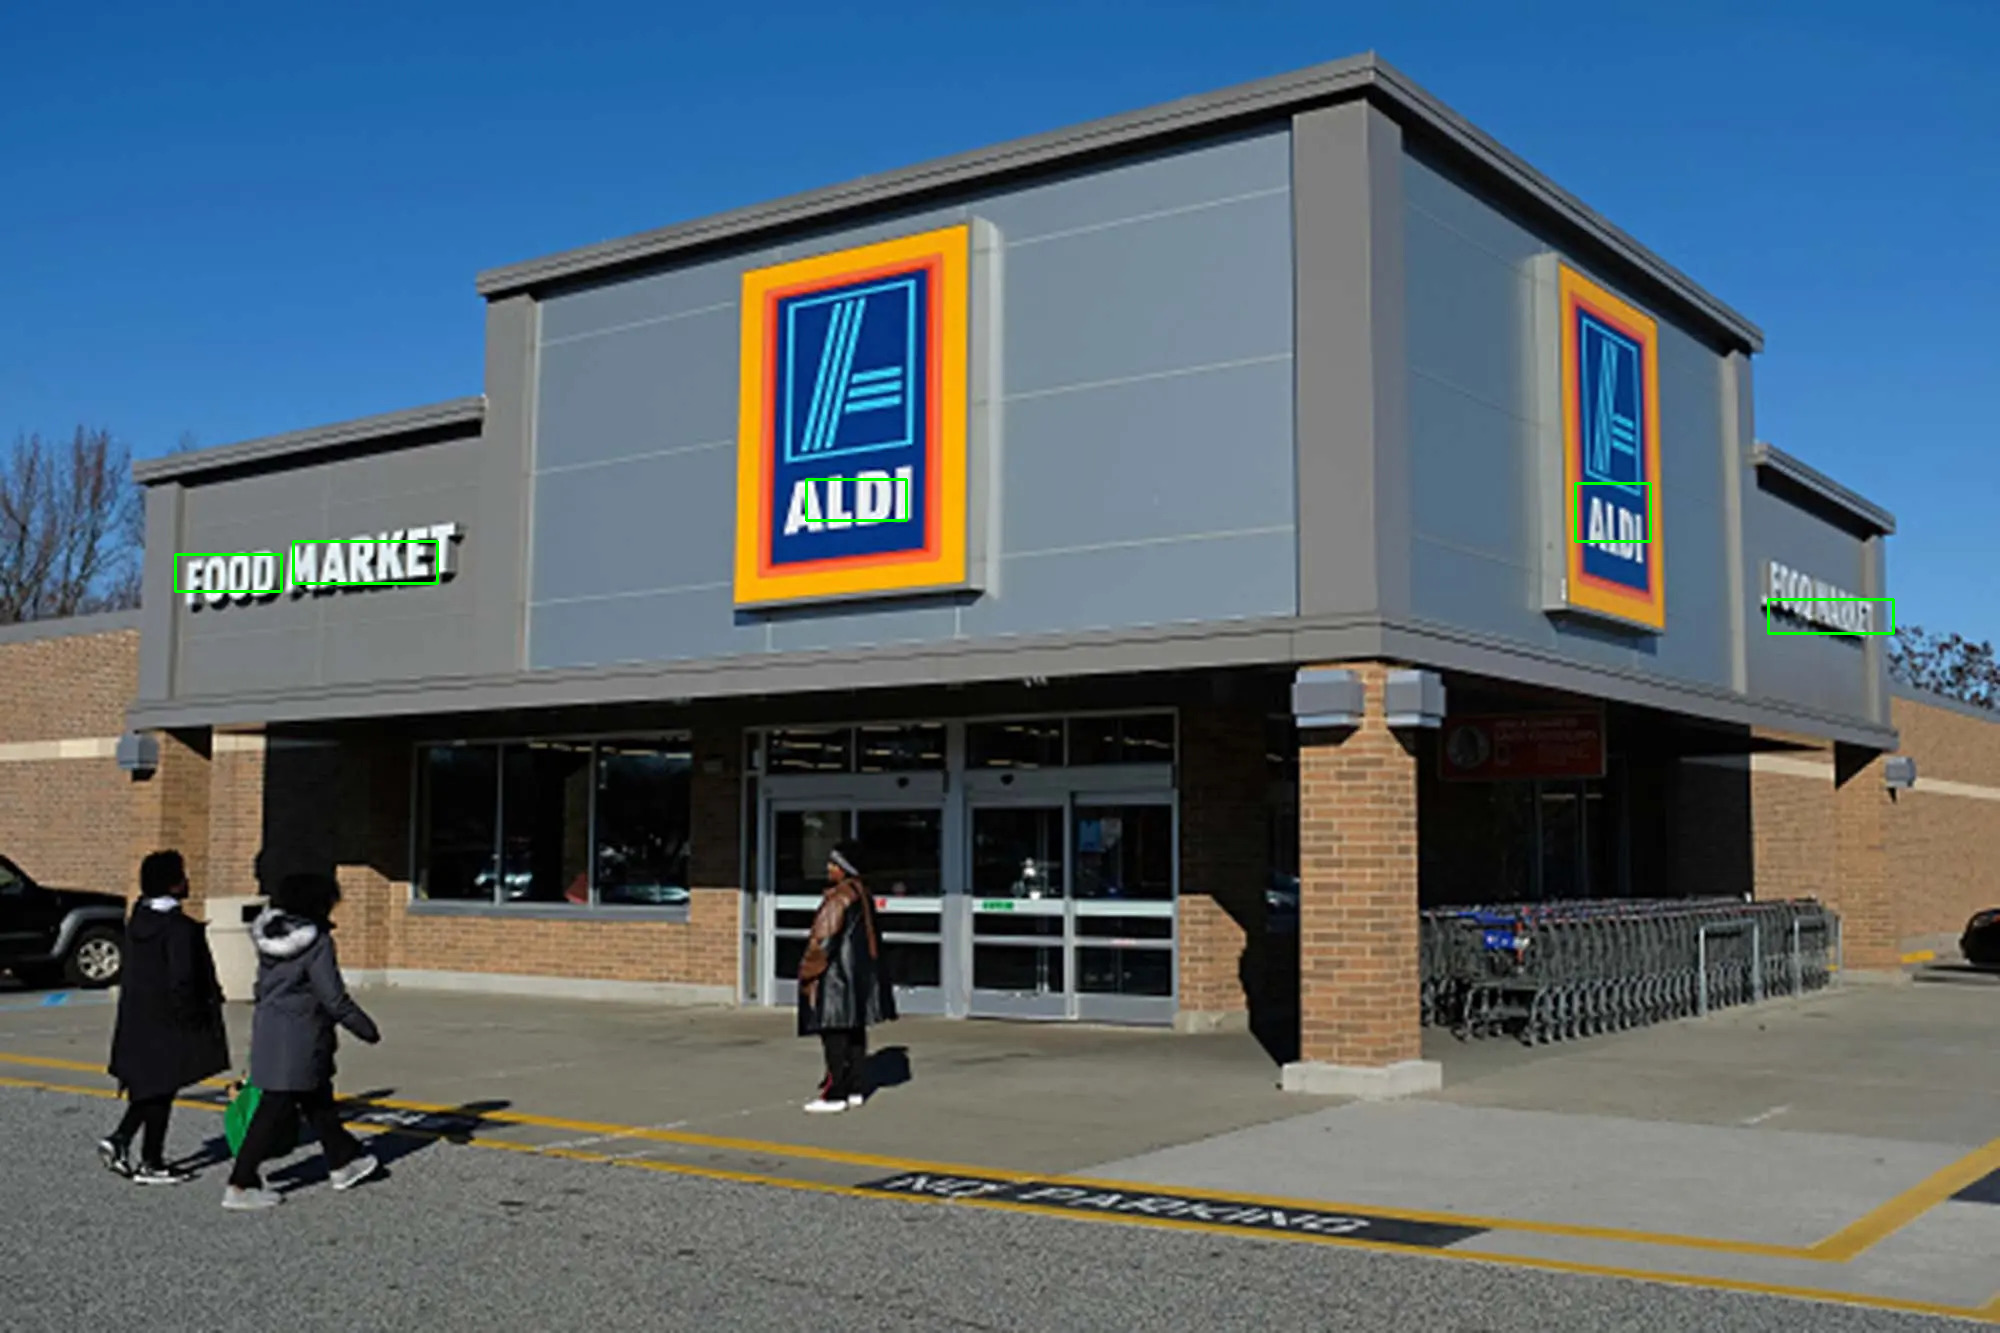

In [16]:
original = cv2.imread("image/store.jpg")
post_process(scores, geometry, rW2, rH2, original)